# Comparaison de la prediction pour Poisson (sdf apprise) avec solution sur-raffinée FEM

In [34]:
import sys
import argparse

from scar.problem.Case import *
from scar.utils import *
from scar.equations.run_Poisson2D import *
from scar.geometry import Geometry2D
from scar.geometry.StandardMesh import *

import dolfin as df
from dolfin import *

## Get SDF and PINNs prediction

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Circle/models/model_3.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])


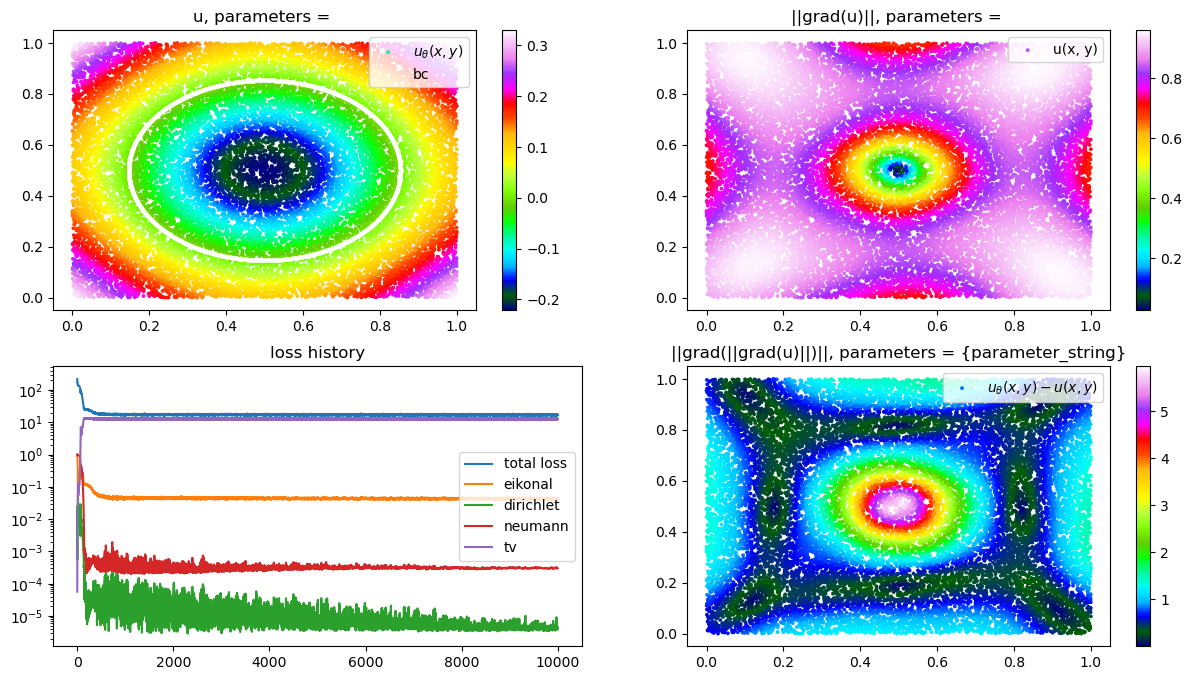

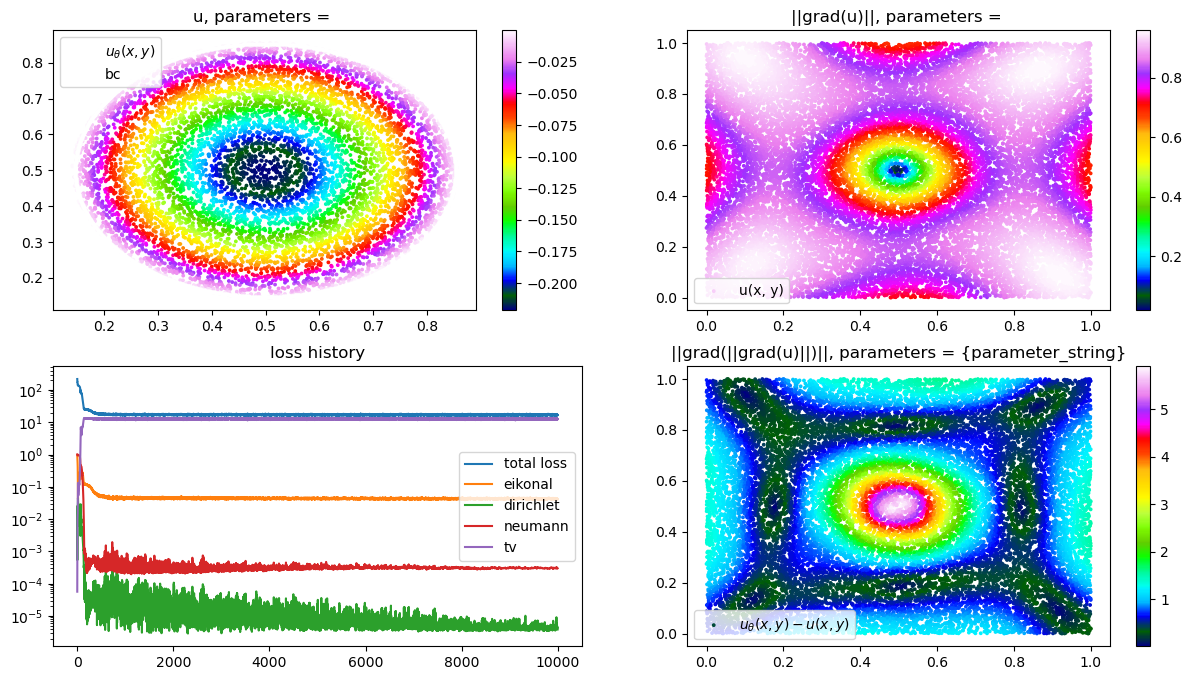

In [35]:
casefile = "../../testcases/"+"form_case_lap.json"
casefile_dict = read_config(casefile)
cas = Case(casefile)
num_config = 2
# geom_class_name = casefile_dict["geometry"]
# geom_class = get_class(geom_class_name,Geometry2D)
# form = geom_class()

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Circle/models/model_3.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
Threshold of the sampling:  0.0
>> load network /home/flecourtier/Bureau/Thèse/networks/Poisson2D/Circle/SDEikonalLap/ConstantForce/form_3/0.0/models/model_2.pth


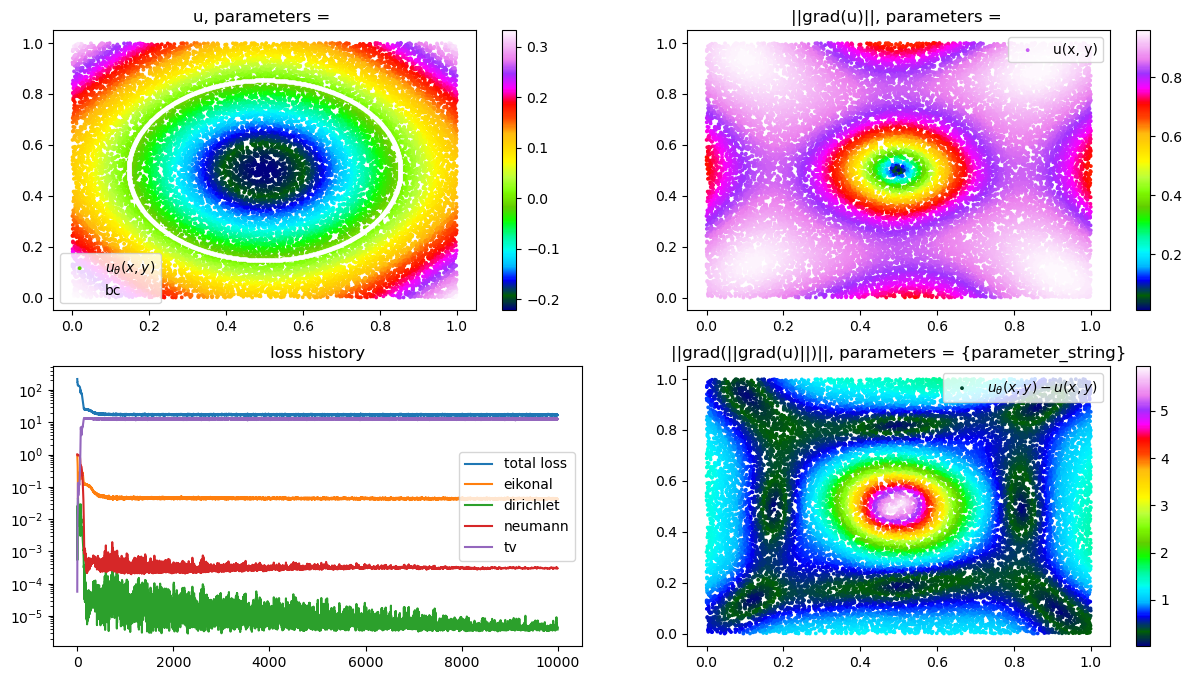

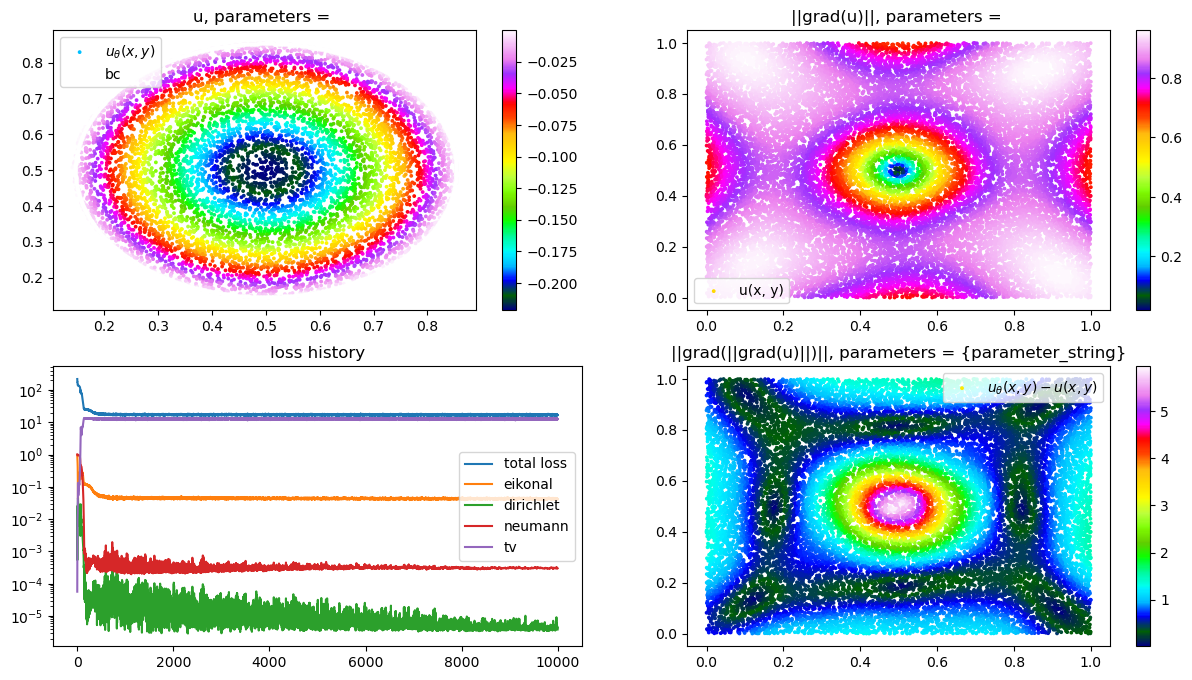

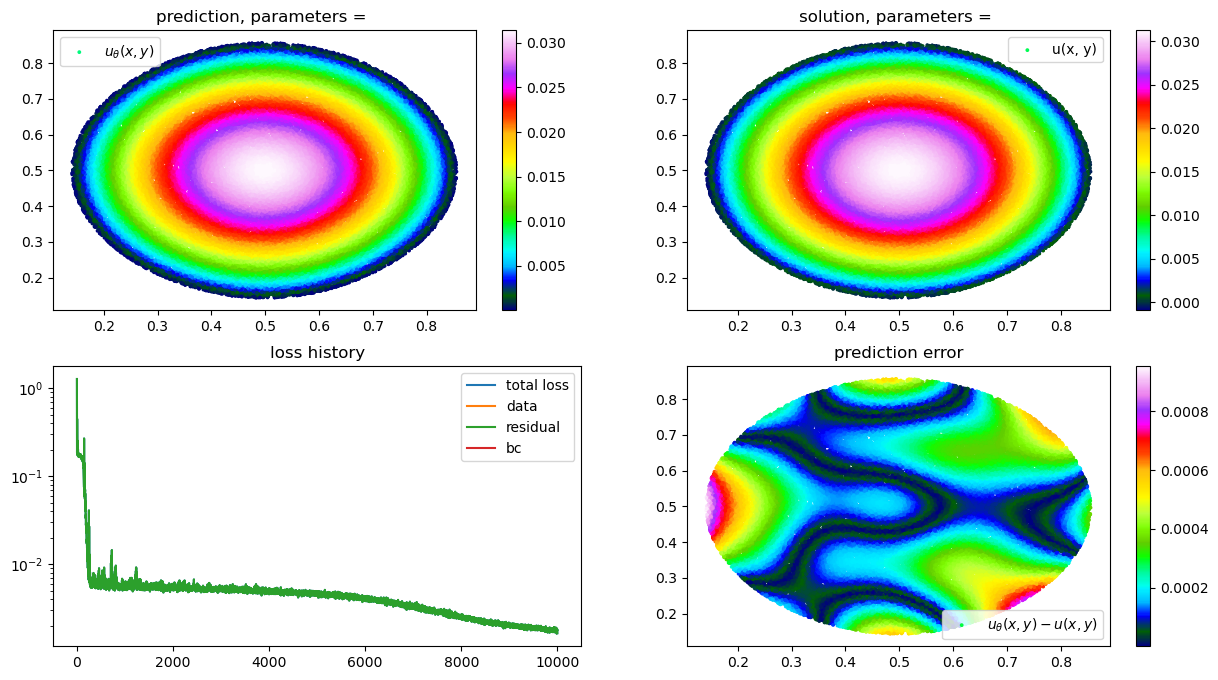

In [36]:
# load model
cas = Case(casefile)

dir_name = "../../"+cas.dir_name
config_filename = dir_name+"models/config_"+str(num_config)+".json"
solution_filename = dir_name+"solutions/compare_ref_levelset_mesh_"+str(num_config)+".png"
config_dict = read_config(config_filename)

trainer = run_Poisson2D(cas,num_config,config_dict,save_sampling=False,save_phi=False,new_training=False);

In [37]:
eik = cas.sd_function.eik_pinns
form_trainer = cas.sd_function.form_trainer

## Get FEM solution

In [38]:
geom_class_name = casefile_dict["geometry"]
geom_class = get_class(geom_class_name,Geometry2D)
form = geom_class()

### Create mesh

In [39]:
mesh_dir = dir_name + "meshes/"
if not os.path.exists(mesh_dir):
    os.makedirs(mesh_dir)
mesh_form = overrefined_mesh(form,form_trainer,mesh_dir)

Reading new mesh from file


In [40]:
# mesh_form

### Get FEM solution

In [41]:
V = FunctionSpace(mesh_form, "CG", 1)
dx = Measure("dx", domain=mesh_form)

g = Constant("0.0")
bc = DirichletBC(V, g, "on_boundary")

f_expr = Constant("1.0")

u = TrialFunction(V)
v = TestFunction(V)

# Resolution of the variationnal problem
a = inner(grad(u), grad(v)) * dx
l = f_expr * v * dx

A = df.assemble(a)
L = df.assemble(l)
bc.apply(A, L)

u_FEM = Function(V)
solve(A,u_FEM.vector(),L)

1

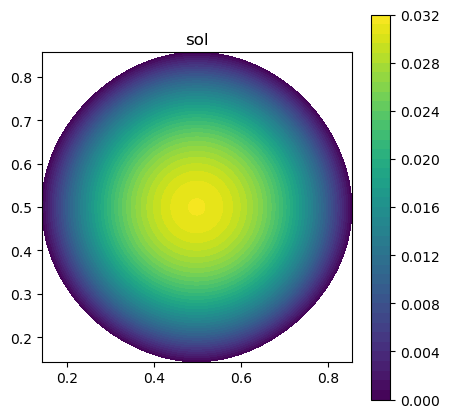

In [42]:
plt.figure(figsize=(5,5))
c = plot(u_FEM, title="sol")
plt.colorbar(c)

## Compare solution

In [43]:
def get_test_sample(V,parameter_domain):
    # get coordinates of the dof
    XXYY = V.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)

    # get parameters
    nb_params = len(parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    if shape[1] == 0:
        mu_test = torch.zeros(shape)
    else:
        ones = torch.ones(shape)
        mu_test = (torch.mean(parameter_domain, axis=1) * ones).to(device)

    return X_test,mu_test

parameter_domain = trainer.pde.parameter_domain
X_test,mu_test = get_test_sample(V,parameter_domain)

pred = trainer.network.setup_w_dict(X_test, mu_test)
phi_tild = pred["w"][:,0].cpu().detach().numpy()
u_PINNs = Function(V)
u_PINNs.vector()[:] = phi_tild.copy()

u_PINNs_inter = interpolate(u_PINNs,V)
norm_L2_PINNs = (assemble((((u_FEM - u_PINNs_inter)) ** 2) * dx) ** (0.5)) / (assemble((((u_FEM)) ** 2) * dx) ** (0.5))

Object cannot be plotted directly, projecting to piecewise linears.


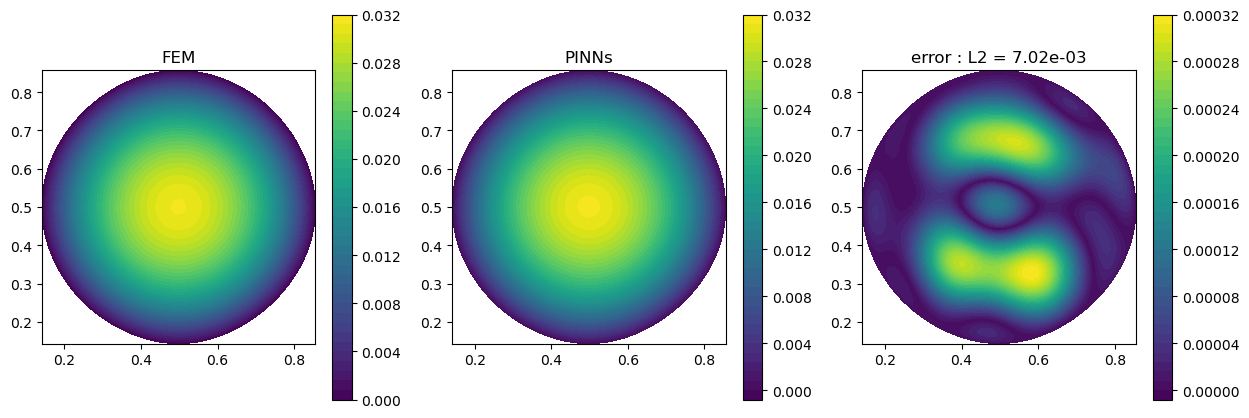

In [44]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
c = plot(u_FEM, title="FEM")
plt.colorbar(c)

plt.subplot(1,3,2)
c = plot(u_PINNs, title="PINNs")
plt.colorbar(c)

plt.subplot(1,3,3)
error = abs(u_FEM-u_PINNs)
c = plot(error, title=f"error : L2 = {norm_L2_PINNs:.2e}")
plt.colorbar(c)

plt.savefig(solution_filename)